In [1]:
import mne 
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix
from tqdm import tqdm

# Helper functions

In [2]:
def get_patients(base_path):
    '''
    Get all patient names
    '''
    return sorted(os.listdir(base_path))

In [3]:
def read_summary(base_path, patient):
    '''
    Read summary of every patient
    '''
    path = os.path.join(base_path, patient)
    files = os.listdir(path)
    for file in files:
        if "summary.txt" in file:
            summary_file = file
            break

    path = os.path.join(path, summary_file)
    with open(path, mode="r") as f:
        lines = f.readlines()
    # get number of seizures in a file
    num_seizure = []
    start_times = []
    end_times = []
    for line in lines:
        if "Number of Seizures in File:" in line:
            n = int(line[-2])
            if n > 0:
                num_seizure.append(n)
                
        if "Start Time:" in line and "Seizure" in line:
            parts = line.split()
            for i, p in enumerate(parts):
                if ":" in p:
                    start_times.append(int(parts[-2]))
                    break

        if "End Time:" in line and "Seizure" in line:
            parts = line.split(" ")
            for i, p in enumerate(parts):
                if ":" in p:
                    end_times.append(int(parts[-2]))
                    break
    return num_seizure, list(zip(start_times, end_times))

In [4]:

def map_ft10(raw):
    '''
    Input parameters:
    raw data
    
    Returns:
    data, labels'''
    df = raw.to_data_frame()
    # np_array = df.to_numpy()
    fp1_f7 = df.loc[:, "FP1-F7"].to_numpy()
    f7_t7 = df.loc[:, "F7-T7"].to_numpy()
    t7_p7 = df.loc[:, "T7-P7"].to_numpy()
    p7_o1 = df.loc[:, "P7-O1"].to_numpy()
    fp1_f3 = df.loc[:, "FP1-F3"].to_numpy()
    f3_c3 = df.loc[:, "F3-C3"].to_numpy()
    c3_p3 = df.loc[:, "C3-P3"].to_numpy()
    p3_o1 = df.loc[:, "P3-O1"].to_numpy()
    fp2_f4 = df.loc[:, "FP2-F4"].to_numpy()
    f4_c4 = df.loc[:, "F4-C4"].to_numpy()
    c4_p4 = df.loc[:, "C4-P4"].to_numpy()
    p4_o2 = df.loc[:, "P4-O2"].to_numpy()
    fp2_f8 = df.loc[:, "FP2-F8"].to_numpy()
    f8_t8 = df.loc[:, "F8-T8"].to_numpy()
    # t8_p8 = df.loc[:, "T8-P8-0"].to_numpy()
    p8_o2 = df.loc[:, "P8-O2"].to_numpy()
    fz_cz = df.loc[:, "FZ-CZ"].to_numpy()
    cz_pz = df.loc[:, "CZ-PZ"].to_numpy()
    p7_t7 = df.loc[:, "P7-T7"].to_numpy()
    t7_ft9 = df.loc[:, "T7-FT9"].to_numpy()
    ft9_ft10 = df.loc[:, "FT9-FT10"].to_numpy()
    ft10_t8 = df.loc[:, "FT10-T8"].to_numpy()
    

    # change the references
    fp1_ft10 = fp1_f7+f7_t7+t7_ft9+ft9_ft10
    f7_ft10 = f7_t7+t7_ft9+ft9_ft10
    t7_ft10 = t7_ft9+ft9_ft10
    p7_ft10 = p7_o1-p3_o1-c3_p3-f3_c3-fp1_f3+fp1_ft10
    # fp1_f3
    f3_ft10 = f3_c3+c3_p3+p3_o1-p7_o1+p7_t7+t7_ft9+ft9_ft10
    c3_ft10 = c3_p3+p3_o1-p7_o1+p7_t7+t7_ft10
    p3_ft10 = p3_o1-p7_o1+p7_t7+t7_ft10
    # fp2_ft10 = fp2_f4+f4_c4+c4_p4+p4_o2-p8_o2-t8_p8-ft10_t8
    # f4_ft10 = f4_c4+c4_p4+p4_o2-p8_o2-t8_p8-ft10_t8
    # c4_ft10 = -f4_c4-f4_ft10
    # p4_ft10 = p4_o2-p8_o2-t8_p8-ft10_t8
    # fp2_f8
    f8_ft10 = f8_t8-ft10_t8
    t8_ft10 = -ft10_t8
    # p8_ft10 = p8_o2-p4_o2+p4_ft10
    data = np.vstack((fp1_ft10, f7_ft10, t7_ft10, p7_ft10, f3_ft10, c3_ft10, p3_ft10, f8_ft10, t8_ft10))
    labels = ["fp1_ft10",
                "f7_ft10",
                "t7_ft10",
                "p7_ft10",
                "f3_ft10",
                "c3_ft10",
                "p3_ft10",
                # "fp2_ft10",
                # "f4_ft10",
                # "c4_ft10",
                # "p4_ft10",
                "f8_ft10",
                "t8_ft10",
                # "p8_ft10",
                ]
    return data, labels

In [5]:
def read_edfs(base_path, patient):
    '''
    Read all edfs of every a patient and return list of dataframes
    '''
    path = os.path.join(base_path, patient)
    # 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
    #    'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
    #    'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
    #    'FT10-T8', 'T8-P8-1'
    include_ch = [
        "FP1-F7",
        "F7-T7",
        "T7-P7",
        "P7-O1",
        "FP1-F3",
        "F3-C3",
        "C3-P3",
        "P3-O1",
        "FP2-F4",
        "F4-C4",
        "C4-P4",
        "P4-O2",
        "FP2-F8",
        "F8-T8",
        "T8-P8-0",
        "P8-O2",
        "FZ-CZ",
        "CZ-PZ",
        "P7-T7",
        "T7-FT9",
        "FT9-FT10",
        "FT10-T8",
    ]
    
    files = sorted(os.listdir(path))
    df_list = []
    # data = []
    for i, file in enumerate(files):
        if ".edf" in file:
            edf = os.path.join(path, file)
            raw_data = mne.io.read_raw_edf(edf, preload=True, include=include_ch, verbose=False)
            # df = raw_data.to_data_frame()
            data, label = map_ft10(raw_data)
            df = pd.DataFrame(data.T, columns=label)
            df_list.append(df)
    
    return df_list
            


- Don't all the partients. Need to clean that up

In [6]:
def build_datasets(base_path):
    all_seizures = []
    all_non_seizures = []
    exclude_patient = ["chb12", "chb24"]
    patients = get_patients(base_path)
    fs = 256
    frame_ln = 256
    for p in patients[:11]:
        if p in exclude_patient:
            continue
        n_seizures, start_end = read_summary(base_path, p)
        df_list = read_edfs(base_path, p)
        print(f"Patient: {p}, Number of seizure:{sum(n_seizures)}")
        idx = 0 # track start_end pair
        for df, n in zip(df_list, n_seizures): # for every edf file
            for _ in range(n): # for each seizure
                start, end = start_end[idx]
                idx += 1
                start_idx = start*fs
                end_idx = end*fs
                seizure = df.loc[50+start_idx:50+start_idx+frame_ln].to_numpy().T # frame during seizure; array of frame length sequences 
                non_seizure = df.loc[start_idx-2*frame_ln-50:start_idx-frame_ln-50].to_numpy().T # frame before seizure; array of frame length sequences 
                seizure = seizure - np.mean(seizure, axis=0)
                non_seizure = non_seizure - np.mean(non_seizure, axis=0)
                all_seizures.append(seizure)
                all_non_seizures.append(non_seizure)
    # data cleaning
    for i, frame in enumerate(all_seizures):
        if frame.shape[1] != 101:
            del all_seizures[i]
    for i, frame in enumerate(all_non_seizures):
        if frame.shape[1] != 101:
            del all_non_seizures[i]
            
    return all_seizures, all_non_seizures

In [7]:
base_path = "./dataset/patients/"
patients = get_patients(base_path)
patients 

['chb01',
 'chb02',
 'chb03',
 'chb04',
 'chb05',
 'chb06',
 'chb07',
 'chb08',
 'chb09',
 'chb10',
 'chb11',
 'chb12',
 'chb13',
 'chb14',
 'chb15',
 'chb16',
 'chb17',
 'chb18',
 'chb19',
 'chb20',
 'chb21',
 'chb22',
 'chb23',
 'chb24']

In [8]:
df = mne.io.read_raw_edf("./dataset/patients/chb01/chb01_03.edf").to_data_frame()
df.columns

Extracting EDF parameters from /Users/raunavghosh/Documents/Estimation and Detection/Estimation-and-Detection/dataset/patients/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/xb/h53k7r3j5_55k9r3s9dzr_tr0000gn/T/ipykernel_39784/4143851149.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  df = mne.io.read_raw_edf("./dataset/patients/chb01/chb01_03.edf").to_data_frame()


Index(['time', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

In [9]:
# seizures, non_seizures = build_datasets(base_path)

# Data cleaning

In [10]:
import pickle
# with open("./dataset/seizure.pkl", mode='wb') as file:
#     pickle.dump(seizures, file, pickle.HIGHEST_PROTOCOL)
# with open("./dataset/non_seizure.pkl", mode='wb') as file:
#     pickle.dump(non_seizures, file, pickle.HIGHEST_PROTOCOL)
with open("./dataset/seizure.pkl", mode='rb') as file:
    seizures = pickle.load(file)
with open("./dataset/non_seizure.pkl", mode='rb') as file:
    non_seizures = pickle.load(file)

In [11]:
# for i, x in enumerate(seizures):
#     if x.shape[0] != 9:
#         print(i, x.shape)
#         del seizures[i]

In [12]:
# for i, x in enumerate(seizures):
#     seizures[i] = np.expand_dims(x, axis=0)
# seizures = np.concatenate(seizures, axis=0)

In [13]:
seizures.shape

(261, 257)

In [14]:
# for i, x in enumerate(non_seizures):
#     if x.shape[0] != 9:
#         print(i, x.shape)
        # del non_seizures[i]

In [15]:
# for i, x in enumerate(non_seizures):
#     non_seizures[i] = np.expand_dims(x, axis=0)
# non_seizures = np.concatenate(non_seizures, axis=0)

In [16]:
non_seizures.shape

(261, 257)

# Feature engineering

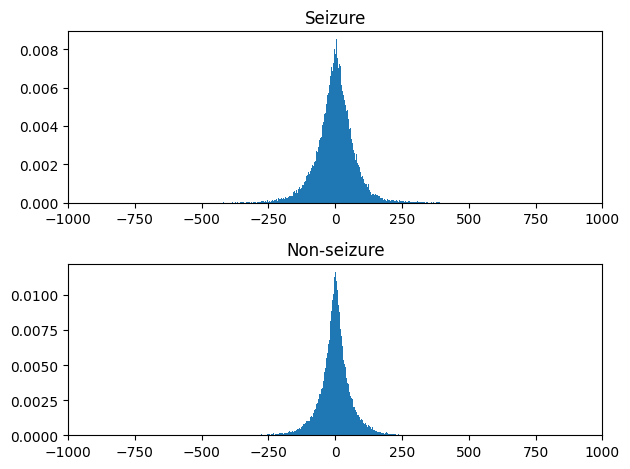

In [17]:
plt.subplot(2,1,1)
plt.hist(seizures.reshape(-1), bins=500, density=True)
plt.title("Seizure")
plt.xlim([-1000, 1000])

plt.subplot(2,1,2)
plt.hist(non_seizures.reshape(-1), bins=500, density=True)
plt.title("Non-seizure")
plt.xlim([-1000, 1000])
plt.tight_layout()
plt.show()

- Mean frames

In [18]:
s_mean = np.mean(seizures, axis=0)
ns_mean = np.mean(non_seizures, axis=0)
s_mean.shape, ns_mean.shape

((257,), (257,))

In [19]:
print(f"Mean vector seizure: {s_mean}")
print(f"Mean vector non-seizure: {ns_mean}")


Mean vector seizure: [-9.52835086e-16 -3.92023578e-15 -1.08895438e-16 -2.06901333e-15
 -1.08895438e-16  3.26686315e-16 -3.81134035e-16  5.71701052e-16
  8.71163507e-16 -1.27952140e-15 -9.80058946e-16 -1.00728281e-15
  8.71163507e-16  2.17790877e-16  6.53372631e-16 -1.08895438e-16
  1.19784982e-15  1.30674526e-15  1.36119298e-15 -1.08895438e-16
 -5.44477192e-16 -1.74232701e-15 -2.17790877e-16  8.71163507e-16
 -1.90567017e-15 -1.06173052e-15  2.17790877e-15 -1.27952140e-15
  1.29313333e-15  1.25229754e-15  6.12536841e-16  3.23963929e-15
  3.59354947e-15  8.43939648e-16  1.79677473e-15 -2.16429684e-15
 -1.91928210e-15 -8.57551578e-16 -2.23235649e-15  1.90567017e-16
 -3.72966877e-15 -1.81038666e-15  5.44477192e-16 -3.40298245e-15
  9.46029121e-16 -1.60620772e-15 -1.61981965e-15 -9.25611227e-16
  5.58089122e-16  1.49731228e-15  1.06173052e-15  1.06173052e-15
  7.35044209e-16  6.53372631e-16 -7.62268069e-16 -2.72238596e-16
  2.06901333e-15  8.16715788e-16  0.00000000e+00 -2.88572912e-15
  1.

- Yellow is higher valued
- Let's figure out which channel has highest variance
- Channel 5 seems quite different valued, let's check distance between channel 5 mean of either class

In [20]:
np.sqrt(np.sum(np.square(s_mean - ns_mean)))

3.383104831786036e-14

In [21]:
for i in range(10):
    print(f"Order of norm: {i}", end="")
    print(np.linalg.norm(s_mean-ns_mean, ord=i))

Order of norm: 0256.0
Order of norm: 14.267824918501013e-13
Order of norm: 23.383104831786036e-14
Order of norm: 31.576745310598433e-14
Order of norm: 41.121932053659592e-14
Order of norm: 59.365235380801768e-15
Order of norm: 68.419486909844854e-15
Order of norm: 77.869237700355526e-15
Order of norm: 87.51927287558457e-15
Order of norm: 97.281563424191665e-15


- Seems quite close.

# Mean

- mean of each frame

In [22]:
meanf_seizure = np.mean(seizures, axis=1)
meanf_nonseizure = np.mean(non_seizures, axis=1)

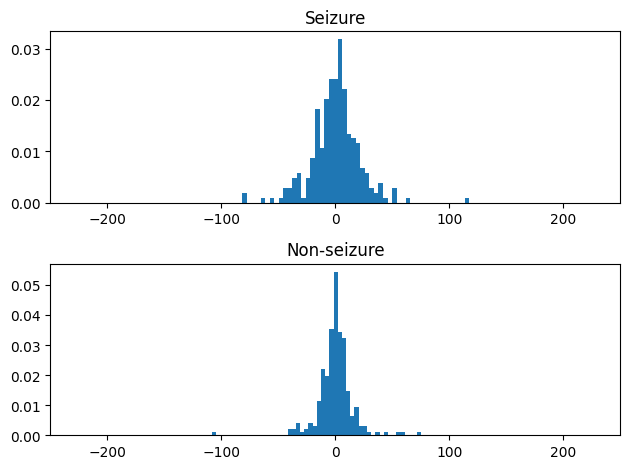

In [23]:
plt.subplot(2,1,1)
plt.hist(meanf_seizure.reshape(-1), bins=50, density=True)
plt.title("Seizure")
plt.xlim([-250, 250])

plt.subplot(2,1,2)
plt.hist(meanf_nonseizure.reshape(-1), bins=50, density=True)
plt.title("Non-seizure")
plt.xlim([-250, 250])
plt.tight_layout()
plt.show()

# Entropy

In [24]:
from scipy.stats import entropy

In [25]:
bins = 100
seizure_distribution, bins1 = np.histogram(seizures.reshape(-1), bins=bins, density=True)
non_seizure_distribution, bins2 = np.histogram(non_seizures.reshape(-1), bins=bins, density=True)

In [26]:
base = 2 # units of bits, working hypothesis(not the one studies in E&D)
H_seiz = entropy(seizure_distribution, base=base)
H_non_seiz = entropy(non_seizure_distribution, base=base)

In [27]:
def find_entropy(vector, bins=10):
    base = 2
    hist, bins1 = np.histogram(vector.reshape(-1), bins=bins, density=True)
    return entropy(hist, base=base)

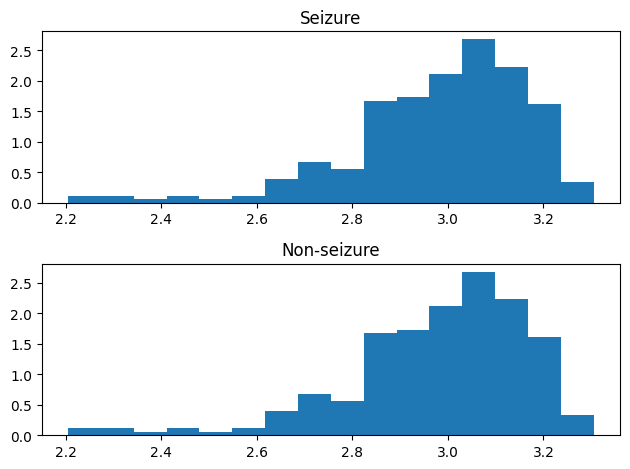

In [28]:
entropy_seiz = []
for vector in seizures:
    entropy_seiz.append(find_entropy(vector))

entropy_nonseiz = []
for vector in non_seizures:
    entropy_nonseiz.append(find_entropy(vector))

plt.subplot(2,1,1)
plt.hist(entropy_seiz, bins="auto", density=True)
plt.title("Seizure")
# plt.xlim([-1000, 1000])

plt.subplot(2,1,2)
plt.hist(entropy_seiz, bins="auto", density=True)
plt.title("Non-seizure")
# plt.xlim([-1000, 1000])
plt.tight_layout()
plt.show()

# Variance

In [29]:
varf_seizure = np.var(seizures, axis=1)
varf_nonseizure = np.var(non_seizures, axis=1)

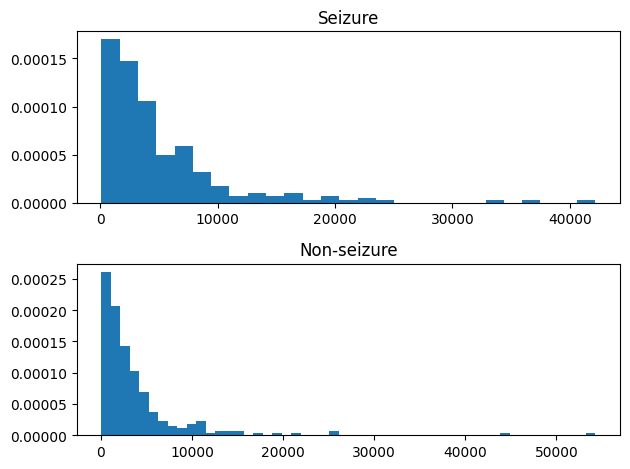

In [30]:
plt.subplot(2,1,1)
plt.hist(varf_seizure, bins="auto", density=True)
plt.title("Seizure")
# plt.xlim([-1000, 1000])

plt.subplot(2,1,2)
plt.hist(varf_nonseizure.reshape(-1), bins="auto", density=True)
plt.title("Non-seizure")
# plt.xlim([-1000, 1000])
plt.tight_layout()
plt.show()

# RMS

In [31]:
s_rms = np.sqrt(np.mean(np.square(seizures), axis=1))
ns_rms = np.sqrt(np.mean(np.square(non_seizures), axis=1))

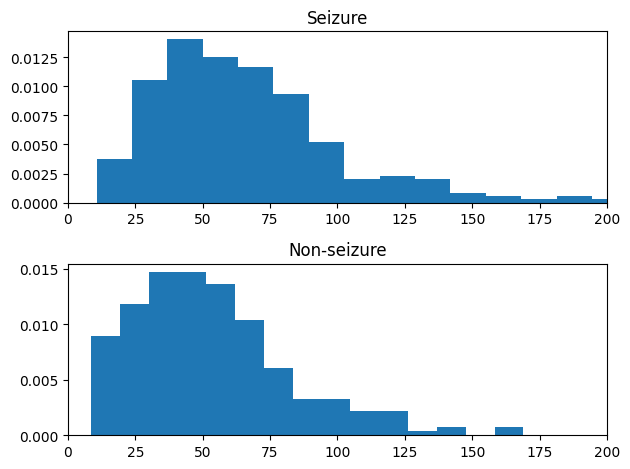

In [32]:
plt.subplot(2,1,1)
plt.hist(s_rms, bins="auto", density=True)
plt.title("Seizure")
plt.xlim([0, 200])

plt.subplot(2,1,2)
plt.hist(ns_rms, bins="auto", density=True)
plt.title("Non-seizure")
plt.xlim([0, 200])
plt.tight_layout()
plt.show()

# Zero crossing rate

In [33]:
from librosa.feature import zero_crossing_rate

In [34]:
s_zcr = zero_crossing_rate(seizures, frame_length=256).reshape(-1)

In [35]:
s_zcr.shape

(261,)

In [36]:
ns_zcr = zero_crossing_rate(non_seizures, frame_length=256).reshape(-1)
ns_zcr.shape

(261,)

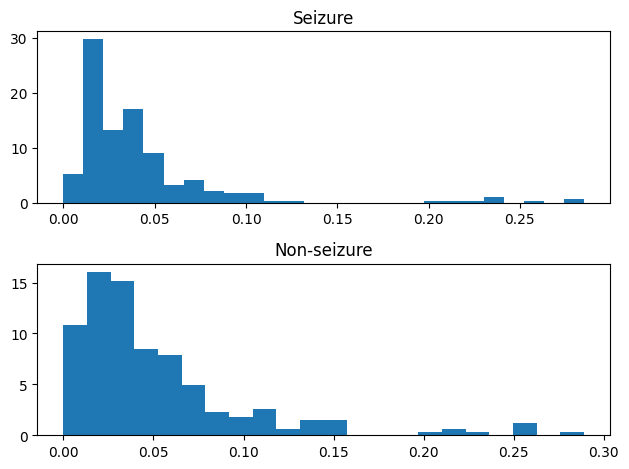

In [37]:
plt.subplot(2,1,1)
plt.hist(s_zcr, bins="auto", density=True)
plt.title("Seizure")
# plt.xlim([-1000, 1000])

plt.subplot(2,1,2)
plt.hist(ns_zcr.reshape(-1), bins="auto", density=True)
plt.title("Non-seizure")
# plt.xlim([-1000, 1000])
plt.tight_layout()
plt.show()

# PCA

In [38]:
from sklearn.decomposition import PCA

In [39]:
s_pca = PCA(n_components=1)
s_pca.fit(seizures)

PCA(n_components=1)

In [40]:
ns_pca = PCA(n_components=1)
ns_pca.fit(non_seizures)

PCA(n_components=1)

In [41]:
seizures_reduced = s_pca.transform(seizures)
non_seizures_reduced = ns_pca.transform(non_seizures)


In [42]:
seizures.shape, seizures_reduced.shape

((261, 257), (261, 1))

In [43]:
non_seizures.shape, non_seizures_reduced.shape

((261, 257), (261, 1))

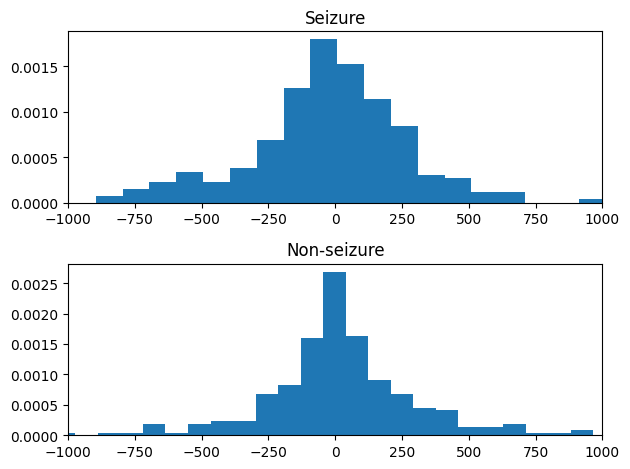

In [44]:
plt.subplot(2,1,1)
plt.hist(seizures_reduced.reshape(-1), bins="auto", density=True)
plt.title("Seizure")
plt.xlim([-1000, 1000])

plt.subplot(2,1,2)
plt.hist(non_seizures_reduced.reshape(-1), bins="auto", density=True)
plt.title("Non-seizure")
plt.xlim([-1000, 1000])
plt.tight_layout()
plt.show()

# Power

In [45]:
from scipy.signal import get_window

In [46]:
import scipy.fftpack as fft

In [47]:
window = get_window("hann", 257, fftbins=True)

In [48]:
seizure_window = seizures * window
non_seizure_window = non_seizures * window


In [49]:
seizure_window.shape, non_seizure_window.shape, 

((261, 257), (261, 257))

In [50]:
seizure_power = np.sum(np.square(seizure_window), axis=1)
non_seizure_power = np.sum(np.square(non_seizure_window), axis=1)

In [51]:
seizure_power.shape, non_seizure_power.shape

((261,), (261,))

In [52]:
np.mean(seizure_power)

535565.0188185434

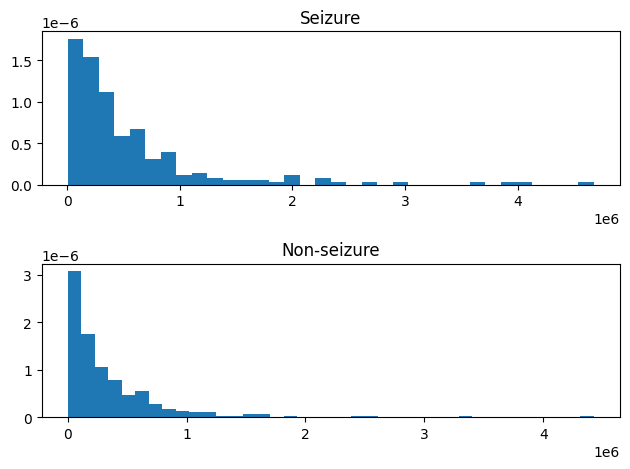

In [53]:
plt.subplot(2,1,1)
plt.hist(seizure_power.reshape(-1), bins='auto', density=True)
plt.title("Seizure")
# plt.xlim([-1000, 1000])

plt.subplot(2,1,2)
plt.hist(non_seizure_power.reshape(-1), bins="auto", density=True)
plt.title("Non-seizure")
# plt.xlim([-1000, 1000])
plt.tight_layout()
plt.show()

# MFCC

In [54]:
from librosa.feature import mfcc


In [55]:
sr = 256
s_mfcc = mfcc(y=seizures, sr=sr, n_mfcc=40, n_fft=256)
s_mfcc = s_mfcc.reshape(-1, 40)

In [56]:
s_mfcc.shape

(261, 40)

In [57]:
sr = 256
ns_mfcc = mfcc(y=non_seizures, sr=sr, n_mfcc=40, n_fft=256)
ns_mfcc = ns_mfcc.reshape(-1, 40)
ns_mfcc.shape

(261, 40)

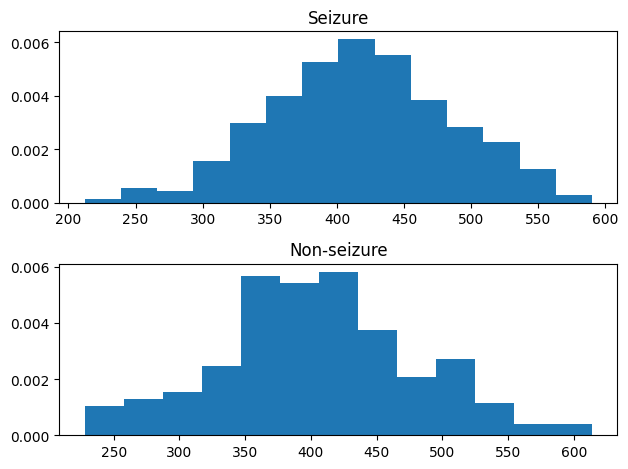

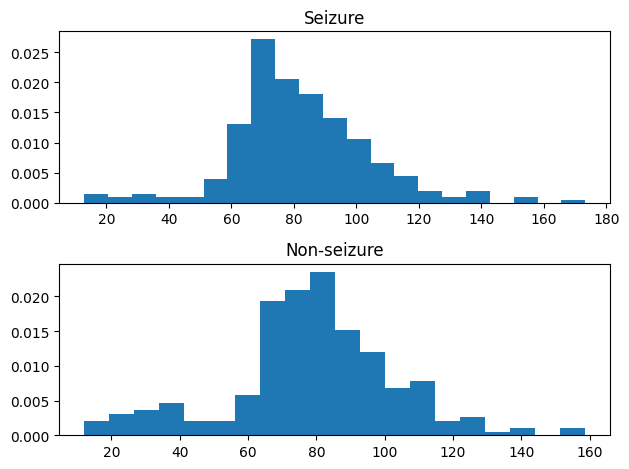

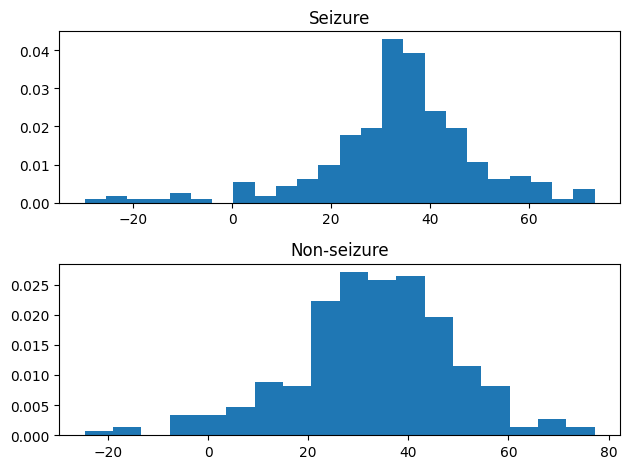

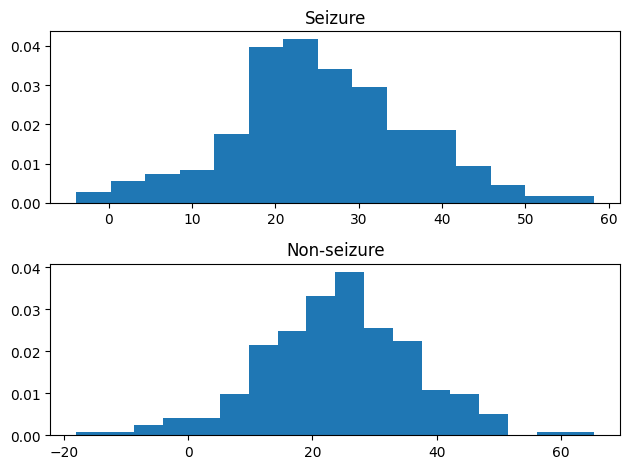

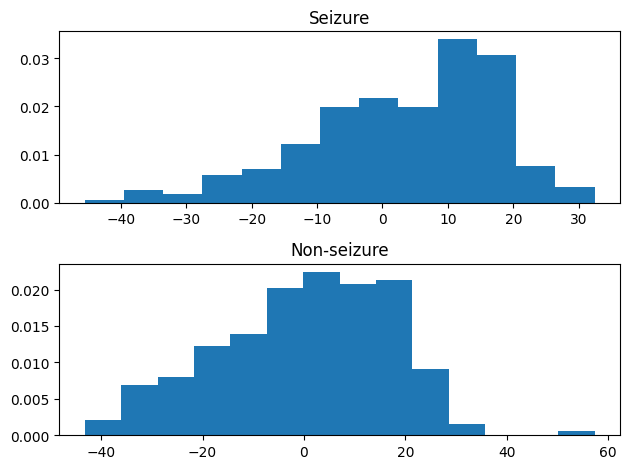

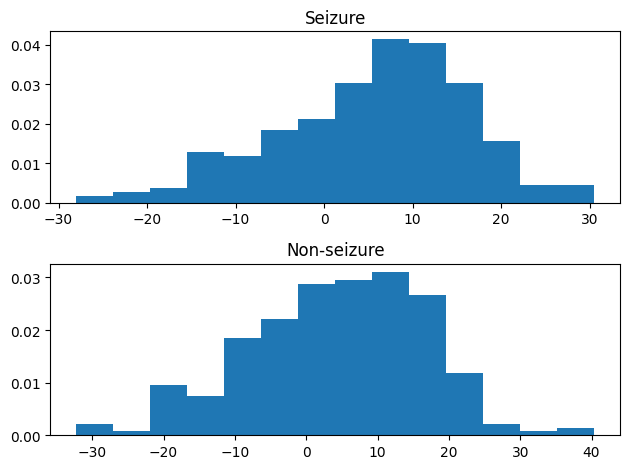

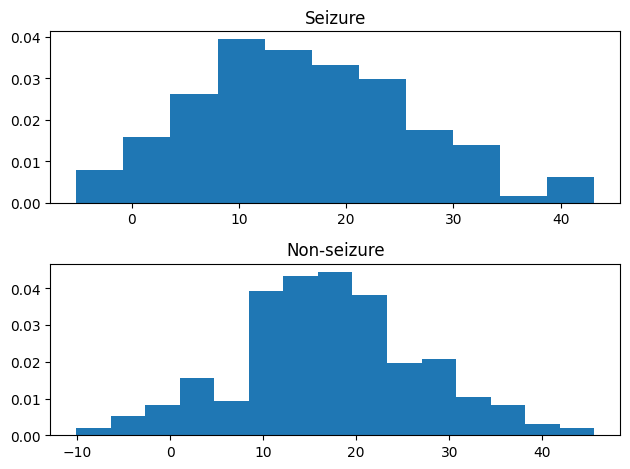

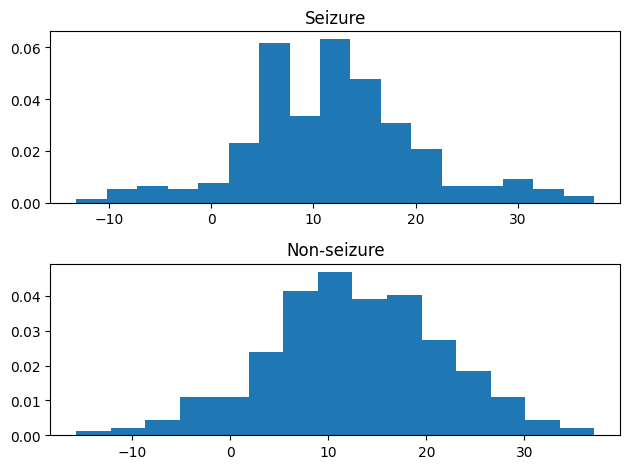

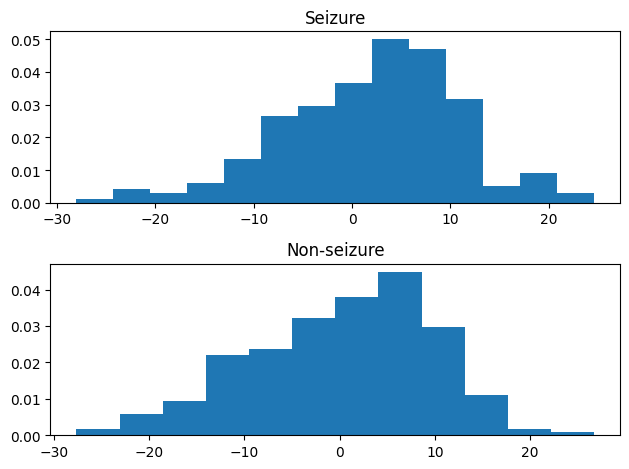

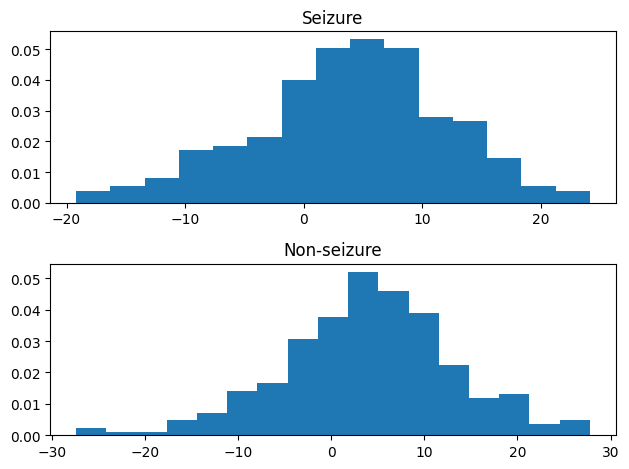

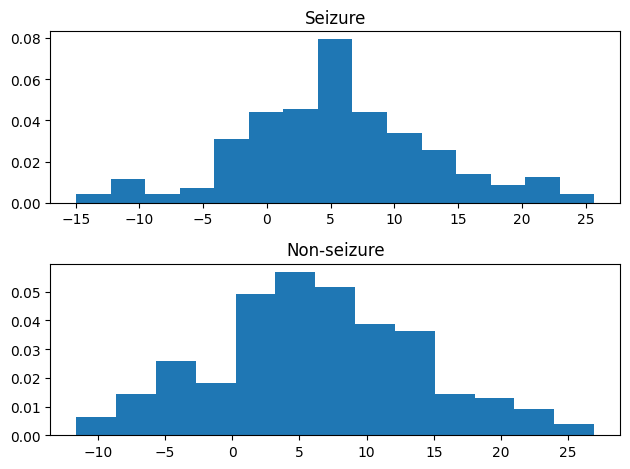

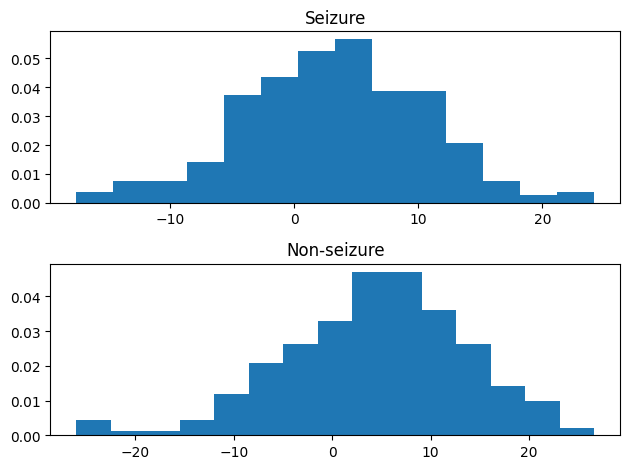

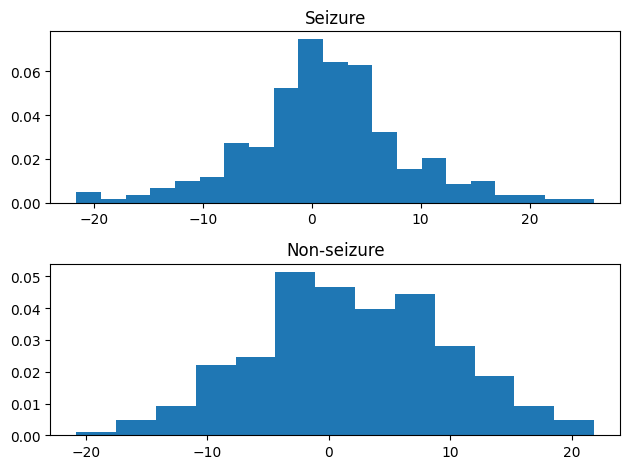

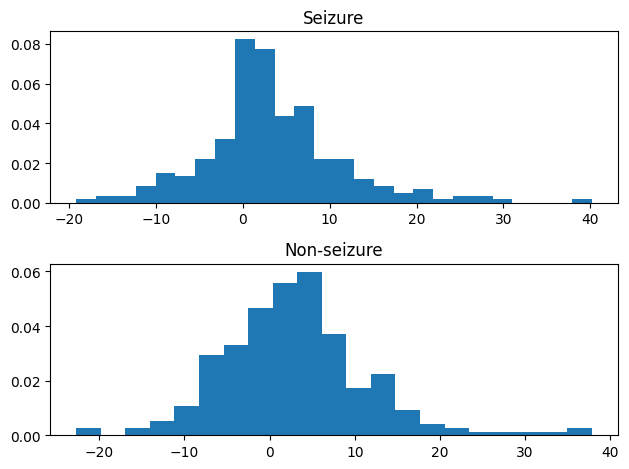

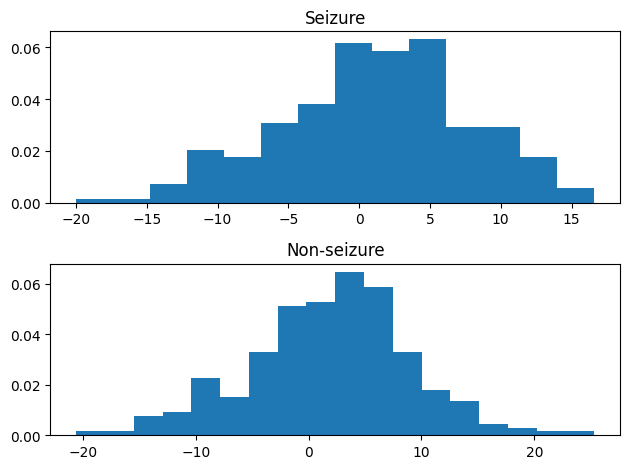

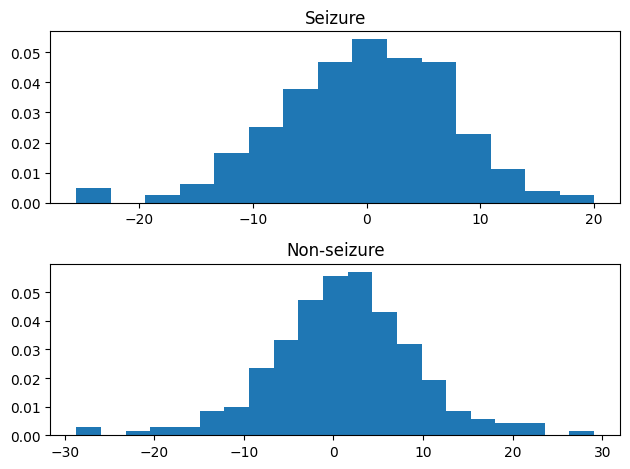

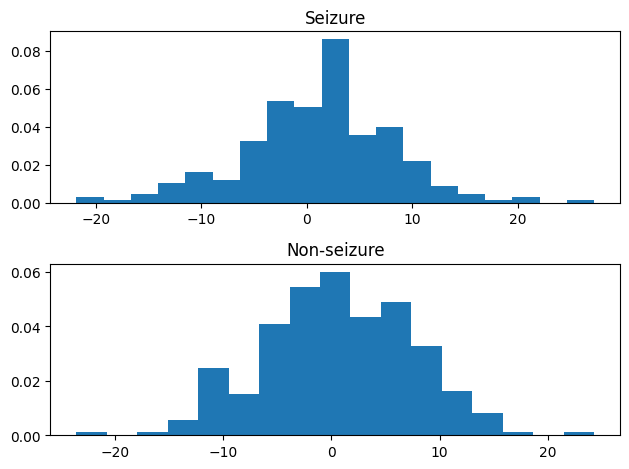

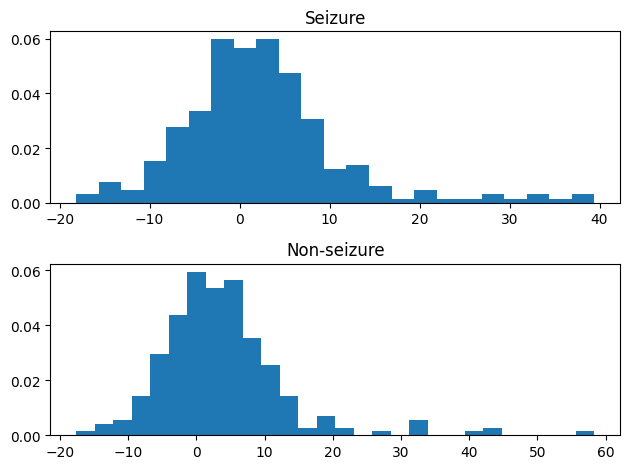

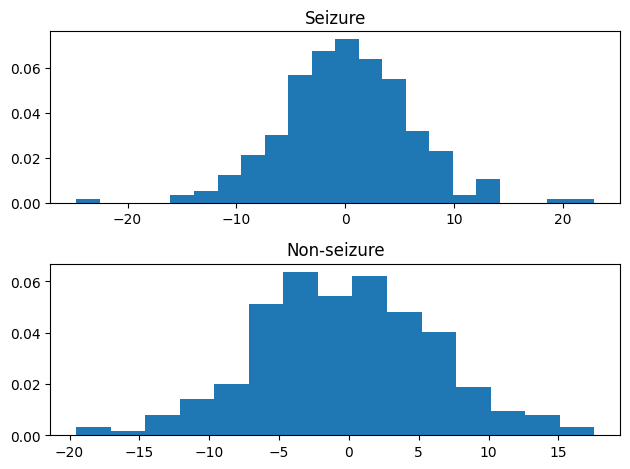

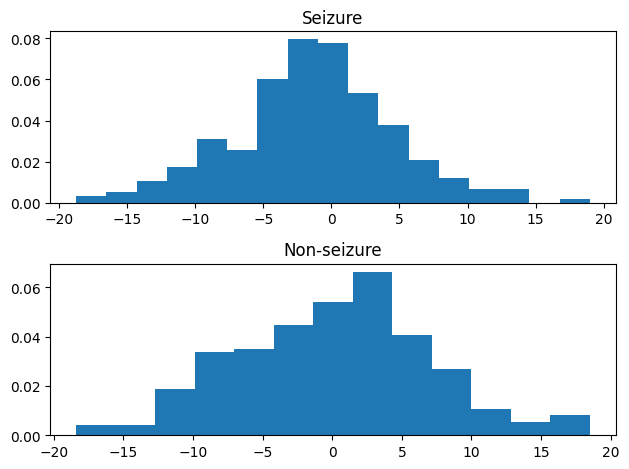

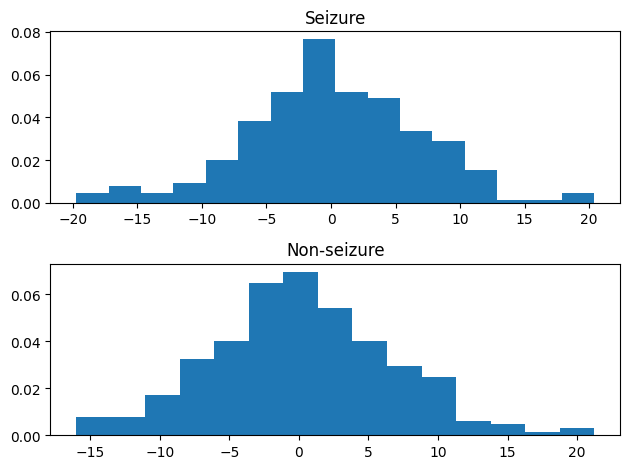

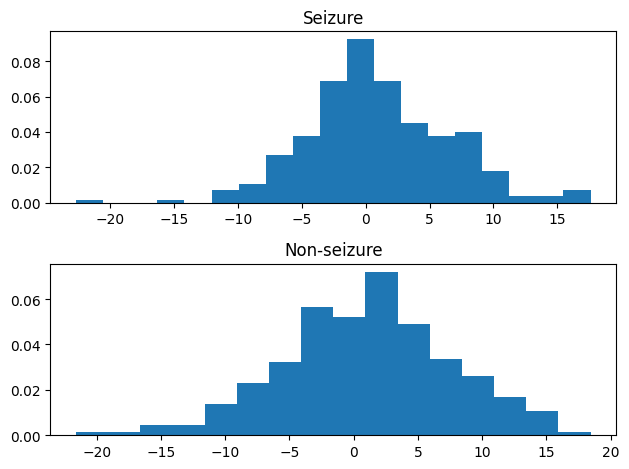

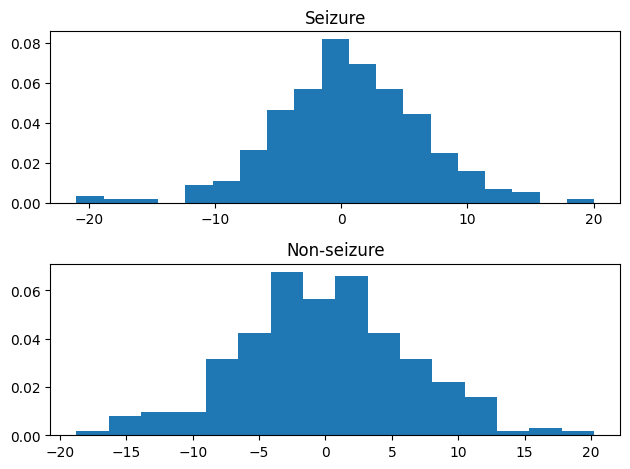

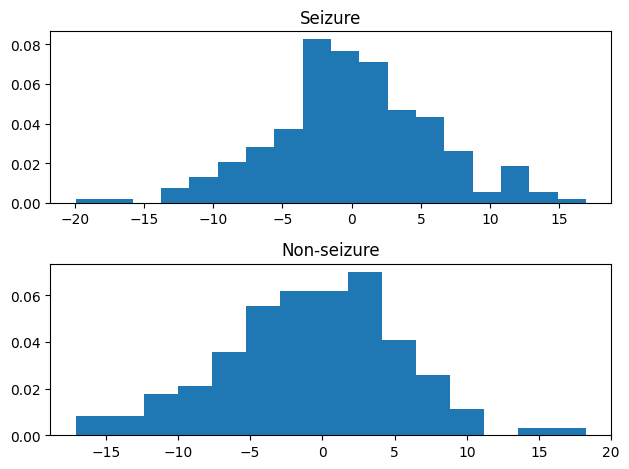

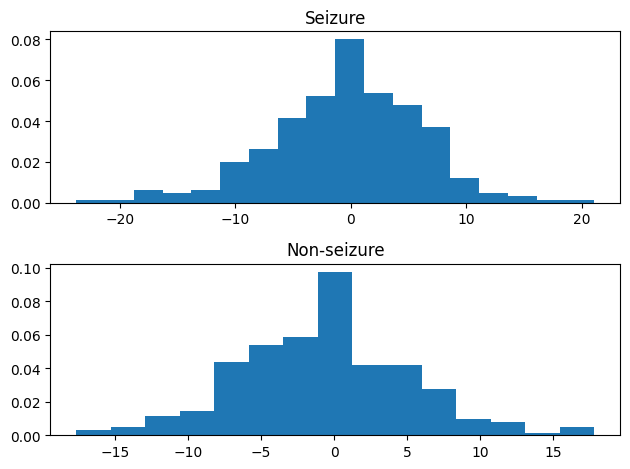

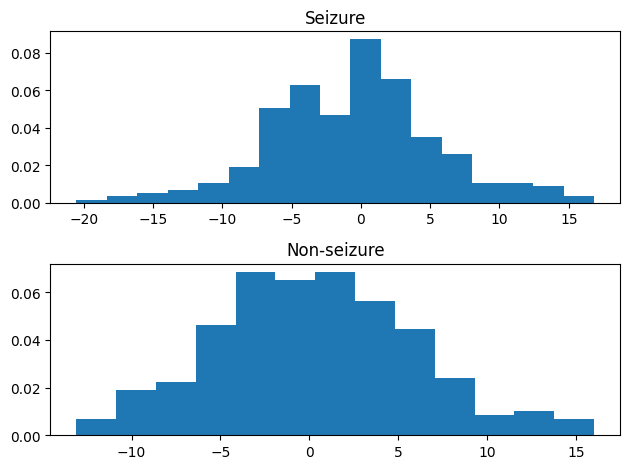

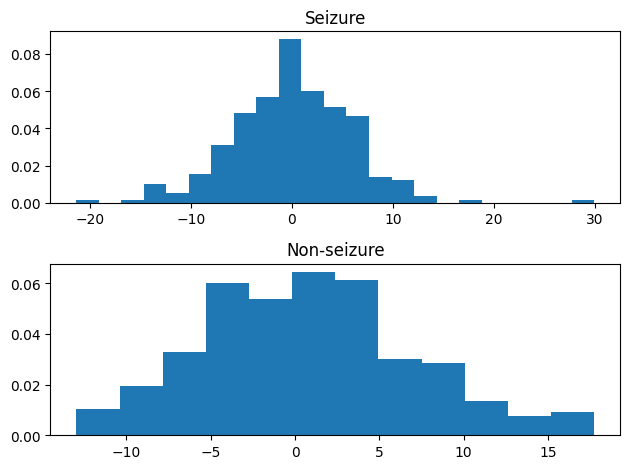

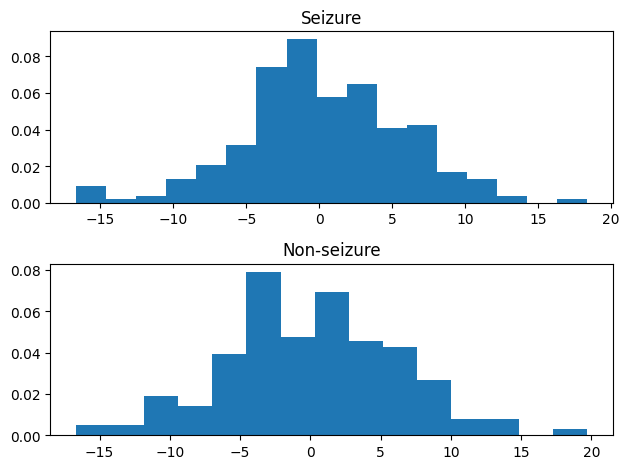

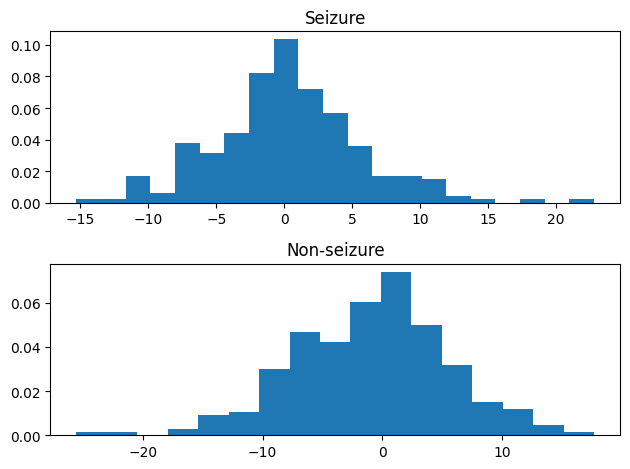

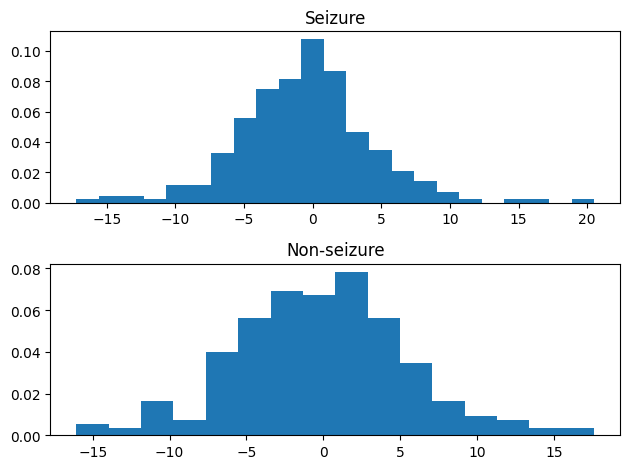

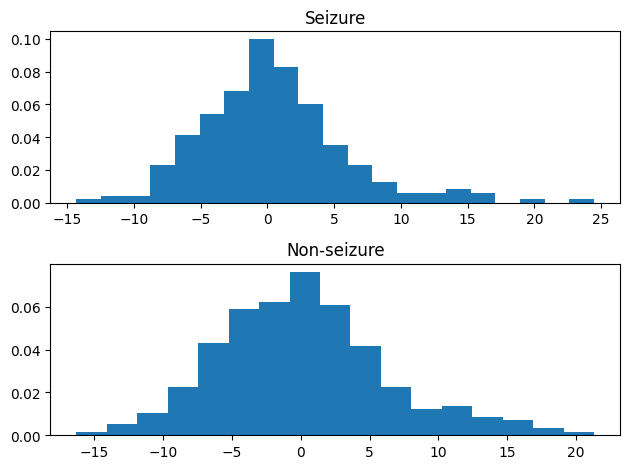

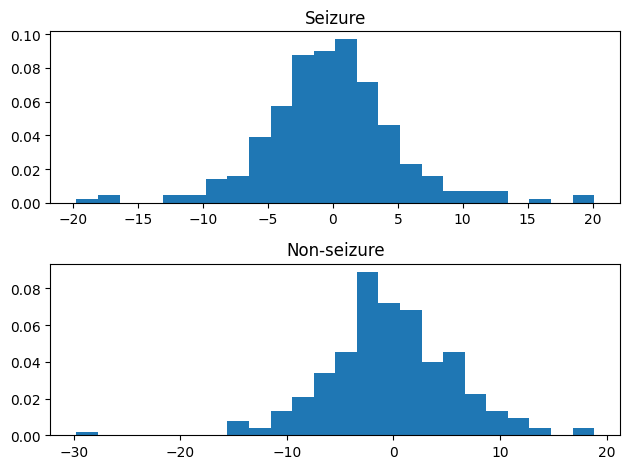

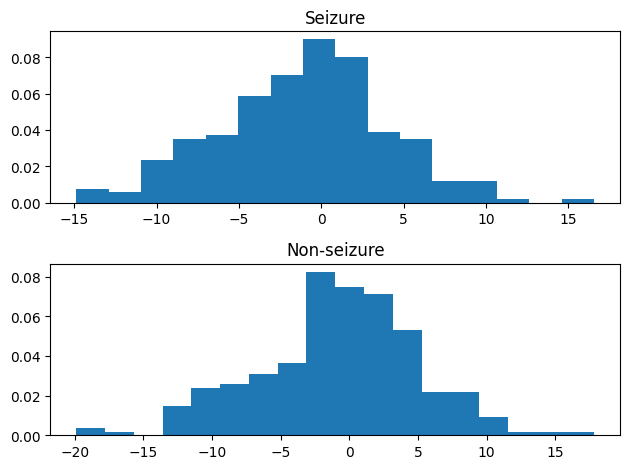

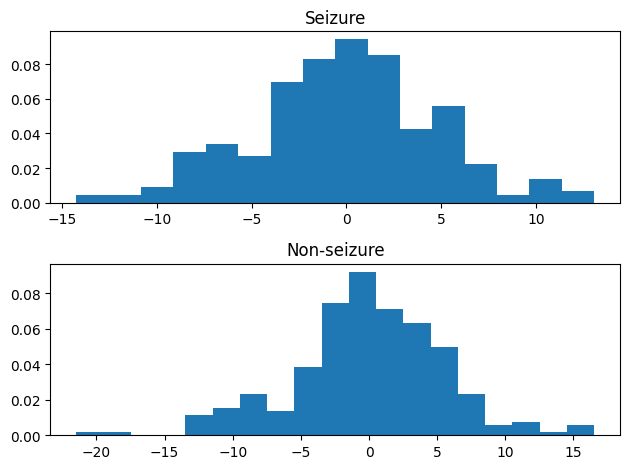

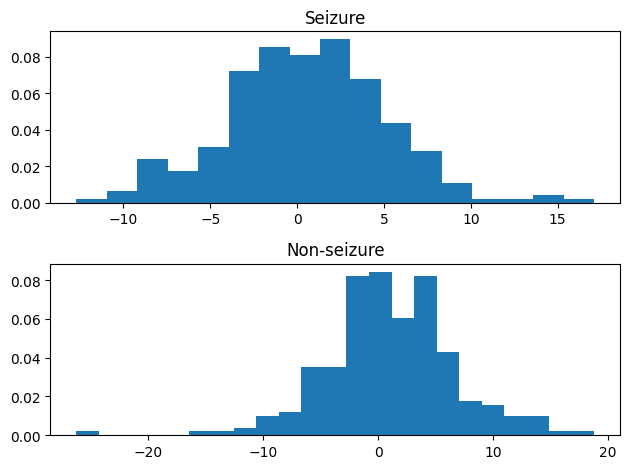

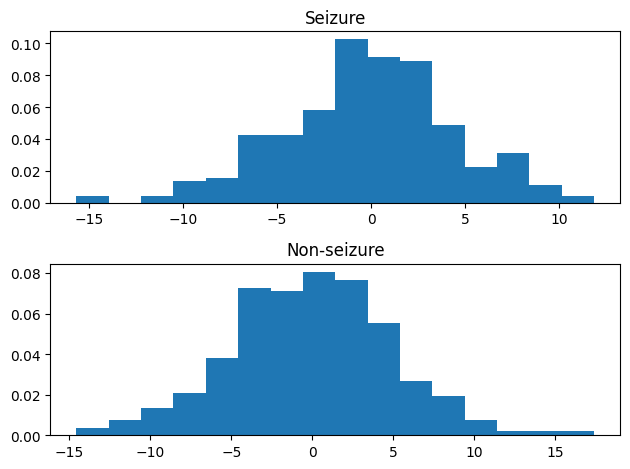

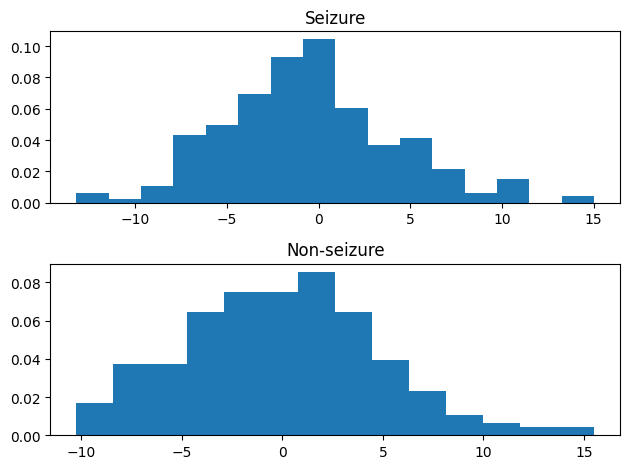

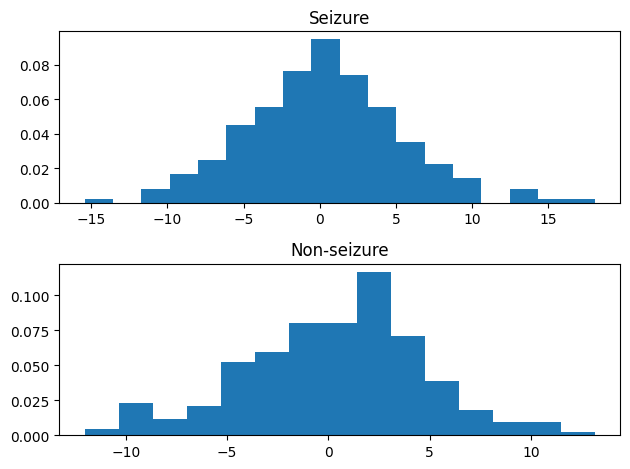

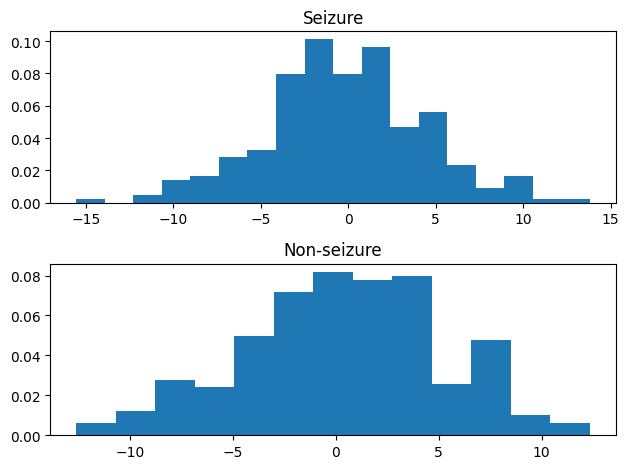

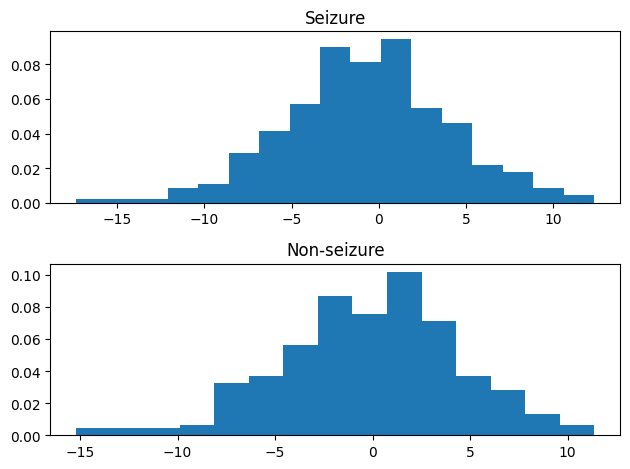

In [58]:
for i in range(40):
    plt.subplot(2,1,1)
    plt.hist(s_mfcc[:, i], bins="auto", density=True)
    plt.title("Seizure") 
    # plt.xlim([-1000, 1000])

    plt.subplot(2,1,2)
    plt.hist(ns_mfcc[:, i], bins="auto", density=True)
    plt.title("Non-seizure")
    # plt.xlim([-1000, 1000])
    plt.tight_layout()
    plt.show()

# Classifier

In [59]:
def build_test_datasets(base_path):
    all_seizures = []
    all_non_seizures = []
    exclude_patient = ["chb24"]
    patients = get_patients(base_path)
    fs = 256
    frame_ln = 256
    for p in patients:
        if p not in exclude_patient:
            continue
        n_seizures, start_end = read_summary(base_path, p)
        df_list = read_edfs(base_path, p)
        print(f"Patient: {p}, Number of seizure:{sum(n_seizures)}")
        idx = 0 # track start_end pair
        for df, n in zip(df_list, n_seizures): # for every edf file
            for _ in range(n): # for each seizure
                start, end = start_end[idx]
                idx += 1
                start_idx = start*fs
                end_idx = end*fs
                seizure = df.loc[50+start_idx:50+start_idx+frame_ln].to_numpy().T # frame during seizure; array of frame length sequences 
                non_seizure = df.loc[start_idx-2*frame_ln-50:start_idx-frame_ln-50].to_numpy().T # frame before seizure; array of frame length sequences 
                seizure = seizure - np.mean(seizure, axis=0)
                non_seizure = non_seizure - np.mean(non_seizure, axis=0)
                all_seizures.append(seizure)
                all_non_seizures.append(non_seizure)
    # data cleaning
    for i, frame in enumerate(all_seizures):
        if frame.shape[1] != 101:
            del all_seizures[i]
    for i, frame in enumerate(all_non_seizures):
        if frame.shape[1] != 101:
            del all_non_seizures[i]
            
            
    return all_seizures, all_non_seizures

In [60]:
test_seizures, test_non_seizures = build_test_datasets(base_path)

Patient: chb24, Number of seizure:16


In [61]:
test_seizures = np.array(test_seizures).reshape(-1, 257)
test_non_seizures = np.array(test_non_seizures).reshape(-1, 257)
test_non_seizures.shape

(72, 257)

In [62]:
def gaussian(x, mean, var):
    den = np.sqrt(2*np.pi)*var
    num = np.exp(0.5*(x-mean)**2 / (var), dtype='float')
    return num/den

In [63]:
def prediction(test_features, threshold, s_mean, ns_mean, s_var, ns_var):
    # threshold = 0.5
    preds = []
    for x in test_features:
        s_lh = gaussian(x, s_mean, s_var)
        ns_lh = gaussian(x, ns_mean, ns_var)

        lrt = s_lh/ns_lh
        if lrt > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return preds


In [64]:
def get_tpr_fpr(true, pred):
    tpr = 0
    fpr = 0
    for t, p  in zip(true, pred):
        if t==1 and p==1:
            tpr += 1
        if t==0 and p==1:
            fpr += 1
    return tpr/len(true), fpr/len(pred)

## Mean

In [65]:
def mean_classifier():
    s_test_rms = np.mean(test_seizures, axis=1)
    ns_test_rms = np.mean(test_non_seizures, axis=1)
    s_test_rms.shape, np.shape(test_seizures)
    test_features = np.concatenate([s_test_rms, ns_test_rms])
    test_labels = np.concatenate([np.ones_like(s_test_rms), np.zeros_like(ns_test_rms)])

    s_mean_rms = np.mean(s_rms)
    ns_mean_rms = np.mean(ns_rms)
    s_mean_rms, ns_mean_rms
    
    s_var_rms = np.var(s_rms)
    ns_var_rms = np.var(ns_rms)
    s_var_rms, ns_var_rms

    tpr_all=[]
    fpr_all=[]
    for threshold in np.arange(0, 1, 0.01):
        pred = prediction(test_features, threshold, s_mean_rms, ns_mean_rms, s_var_rms, ns_var_rms)
        tpr, fpr = get_tpr_fpr(test_labels, pred)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    plt.plot(fpr_all, tpr_all)
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

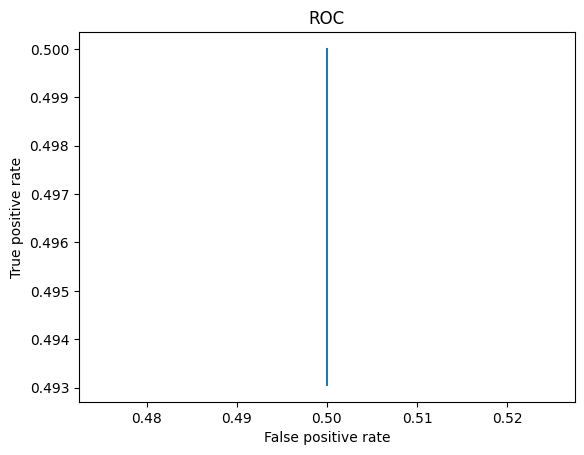

In [66]:
mean_classifier()

## RMS

In [67]:
def rms_classifier():
    s_test_rms = np.sqrt(np.mean(np.square(test_seizures), axis=1))
    ns_test_rms = np.sqrt(np.mean(np.square(test_non_seizures), axis=1))
    s_test_rms.shape, np.shape(test_seizures)
    test_features = np.concatenate([s_test_rms, ns_test_rms])
    test_labels = np.concatenate([np.ones_like(s_test_rms), np.zeros_like(ns_test_rms)])

    s_mean_rms = np.mean(s_rms)
    ns_mean_rms = np.mean(ns_rms)
    s_mean_rms, ns_mean_rms
    
    s_var_rms = np.var(s_rms)
    ns_var_rms = np.var(ns_rms)
    s_var_rms, ns_var_rms

    tpr_all=[]
    fpr_all=[]
    for threshold in np.arange(0, 1, 0.01):
        pred = prediction(test_features, threshold, s_mean_rms, ns_mean_rms, s_var_rms, ns_var_rms)
        tpr, fpr = get_tpr_fpr(test_labels, pred)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    plt.plot(tpr_all, fpr_all)
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

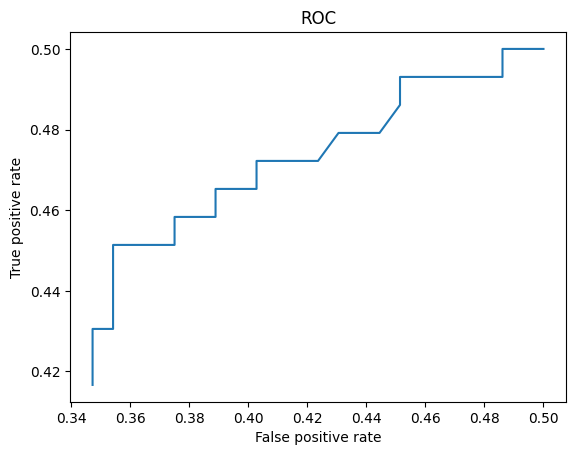

In [68]:
rms_classifier()

## Var

In [69]:
def var_classifier():
    s_test_var = np.var(test_seizures, axis=1)
    ns_test_var = np.var(test_non_seizures, axis=1)
    s_test_var.shape, np.shape(test_seizures)
    test_features = np.concatenate([s_test_var, ns_test_var])
    test_labels = np.concatenate([np.ones_like(s_test_var), np.zeros_like(ns_test_var)])

    s_mean_var = np.mean(varf_seizure)
    ns_mean_var = np.mean(varf_nonseizure)
    s_mean_var, ns_mean_var
    
    s_var_var = np.var(varf_seizure)
    ns_var_var = np.var(varf_nonseizure)
    s_var_var, ns_var_var
    

    tpr_all=[]
    fpr_all=[]
    for threshold in np.arange(0, 1, 0.01):
        pred = prediction(test_features, threshold, s_mean_var, ns_mean_var, s_var_var, ns_var_var)
        tpr, fpr = get_tpr_fpr(test_labels, pred)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    plt.plot( tpr_all, fpr_all)
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

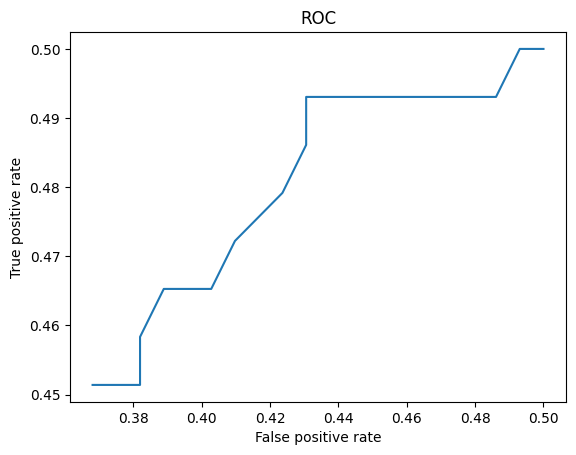

In [70]:
var_classifier()

## Entropy

In [71]:
def entropy_classifier():
    s_test_entropy = []
    for vector in test_seizures:
        s_test_entropy.append(find_entropy(vector))

    ns_test_entropy = []
    for vector in test_non_seizures:
        ns_test_entropy.append(find_entropy(vector))
    # s_test_var.shape, np.shape(test_seizures)
    test_features = np.concatenate([s_test_entropy, ns_test_entropy])
    # print(test_features.shape)
    test_labels = np.concatenate([np.ones_like(s_test_entropy), np.zeros_like(ns_test_entropy)])

    s_mean_var = np.mean(H_seiz)
    ns_mean_var = np.mean(H_non_seiz)
    s_mean_var, ns_mean_var
    
    s_var_var = np.var(H_seiz)
    ns_var_var = np.var(H_non_seiz)
    s_var_var, ns_var_var

    tpr_all=[]
    fpr_all=[]
    for threshold in np.arange(0, 1, 0.01):
        pred = prediction(test_features, threshold, s_mean_var, ns_mean_var, s_var_var, ns_var_var)
        tpr, fpr = get_tpr_fpr(test_labels, pred)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    plt.plot(fpr_all, tpr_all)
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

/var/folders/xb/h53k7r3j5_55k9r3s9dzr_tr0000gn/T/ipykernel_39784/2036968523.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  num = np.exp(0.5*(x-mean)**2 / (var), dtype='float')
/var/folders/xb/h53k7r3j5_55k9r3s9dzr_tr0000gn/T/ipykernel_39784/3568025852.py:8: RuntimeWarning: invalid value encountered in double_scalars
  lrt = s_lh/ns_lh


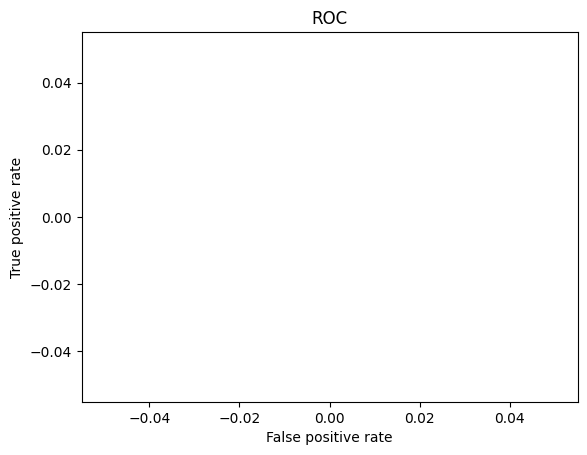

In [72]:
entropy_classifier()

## ZCR

In [73]:
def zcr_classifier():
    s_test_rms = zero_crossing_rate(test_seizures, frame_length=256).reshape(-1)
    ns_test_rms = zero_crossing_rate(test_non_seizures, frame_length=256).reshape(-1)
    s_test_rms.shape, np.shape(test_seizures)
    test_features = np.concatenate([s_test_rms, ns_test_rms])
    test_labels = np.concatenate([np.ones_like(s_test_rms), np.zeros_like(ns_test_rms)])

    s_mean_rms = np.mean(s_rms)
    ns_mean_rms = np.mean(ns_rms)
    s_mean_rms, ns_mean_rms
    
    s_var_rms = np.var(s_rms)
    ns_var_rms = np.var(ns_rms)
    s_var_rms, ns_var_rms

    tpr_all=[]
    fpr_all=[]
    for threshold in np.arange(0, 1, 0.01):
        pred = prediction(test_features, threshold, s_mean_rms, ns_mean_rms, s_var_rms, ns_var_rms)
        tpr, fpr = get_tpr_fpr(test_labels, pred)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    plt.plot(fpr_all, tpr_all)
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

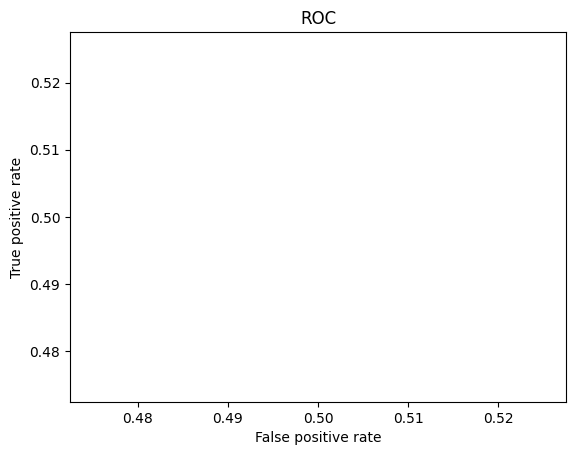

In [74]:
zcr_classifier()

In [75]:
def exp_distibution(x, lam):
    if x < 0:
        return 0
    return lam*np.exp(-x*lam)

## Power

In [76]:
def power_classifier():
    window = get_window("hann", 257, fftbins=True)
    seizure_window = test_seizures * window
    non_seizure_window = test_non_seizures * window
    test_seizure_power = np.sum(np.square(seizure_window), axis=1)
    test_non_seizure_power = np.sum(np.square(non_seizure_window), axis=1)
    # s_test_var.shape, np.shape(test_seizures)
    test_features = np.concatenate([test_seizure_power, test_non_seizure_power])
    test_labels = np.concatenate([np.ones_like(test_seizure_power), np.zeros_like(test_non_seizure_power)])

    s_mean_var = np.mean(seizure_power)
    ns_mean_var = np.mean(non_seizure_power)
    s_mean_var, ns_mean_var
    
    s_var_var = np.var(seizure_power)
    ns_var_var = np.var(non_seizure_power)
    s_var_var, ns_var_var
    

    tpr_all=[]
    fpr_all=[]
    for threshold in np.arange(0, 1, 0.01):
        pred = prediction(test_features, threshold, s_mean_var, ns_mean_var, s_var_var, ns_var_var)
        tpr, fpr = get_tpr_fpr(test_labels, pred)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    plt.plot( tpr_all, fpr_all)
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

/var/folders/xb/h53k7r3j5_55k9r3s9dzr_tr0000gn/T/ipykernel_39784/2036968523.py:3: RuntimeWarning: overflow encountered in exp
  num = np.exp(0.5*(x-mean)**2 / (var), dtype='float')


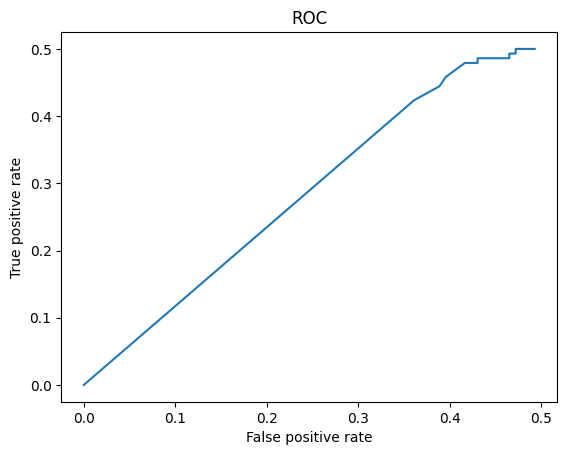

In [77]:
power_classifier()

## Multiple features

In [91]:
# multivariate class conditional density function 
def gaussian_ccd(x_, mean_, cov_m):
    x = np.reshape(x_, newshape = (3, 1)) #converting to column vector
    mean = np.reshape(mean_, newshape = (3, 1)) #converting to column vector
    inv_cov_m = np.linalg.pinv(cov_m)
    det_cov_m = np.linalg.det(cov_m)
    ex = np.exp(-0.5 * np.matmul((x - mean).T, np.matmul(inv_cov_m, (x - mean))))
    return (1/(((2 * np.pi) ** (len(x)/2)) * det_cov_m**0.5)) * ex

In [100]:
gaussian_ccd([3,1,1], [0,0,0], [[1,0,0], [0,1,0], [0,0,1]])[0,0]

0.00025948397786029173

In [110]:
def multiple_features():
    # Power
    window = get_window("hann", 257, fftbins=True)
    seizure_window = test_seizures * window
    non_seizure_window = test_non_seizures * window
    test_seizure_power = np.sum(np.square(seizure_window), axis=1)
    test_non_seizure_power = np.sum(np.square(non_seizure_window), axis=1)
    power_features = np.concatenate([test_seizure_power, test_non_seizure_power])

    # Var
    s_test_var = np.var(test_seizures, axis=1)
    ns_test_var = np.var(test_non_seizures, axis=1)
    s_test_var.shape, np.shape(test_seizures)
    var_features = np.concatenate([s_test_var, ns_test_var])

    # rms
    s_test_rms = np.sqrt(np.mean(np.square(test_seizures), axis=1))
    ns_test_rms = np.sqrt(np.mean(np.square(test_non_seizures), axis=1))
    s_test_rms.shape, np.shape(test_seizures)
    rms_features = np.concatenate([s_test_rms, ns_test_rms])
    test_labels = np.concatenate([np.ones_like(s_test_rms), np.zeros_like(ns_test_rms)])

    test_features = np.vstack([power_features, var_features, rms_features]).T
    # print(test_features.shape)

    train_features_seizure = np.vstack([seizure_power, varf_seizure, s_rms]).T
    train_features_non_seizure = np.vstack([non_seizure_power, varf_nonseizure, ns_rms]).T

    # print(train_features_non_seizure.shape)
    seizure_cov = np.cov(train_features_seizure.T)
    non_seizure_cov = np.cov(train_features_non_seizure.T)
    # print(non_seizure_cov)

    seizure_mean = np.mean(train_features_seizure, axis=0)
    non_seizure_mean = np.mean(train_features_non_seizure, axis=0)
    # print(seizure_mean)
    prior = 0.5

    def classifier(feature_vectors, mean_set, cov_set):
        # ignoring evidance for comparison
        ratios = []
        for x in tqdm(feature_vectors):
            lh_s = gaussian_ccd(x, mean_set[0], cov_set[0])[0,0]
            lh_ns = gaussian_ccd(x, mean_set[1], cov_set[1])[0,0]
            ratio = lh_s/lh_ns
            ratios.append(ratios)
        return ratios
    ratios = classifier(test_features, [seizure_mean, non_seizure_mean], [seizure_cov, non_seizure_cov])

    
    return ratios, test_labels




    
    
    
    

In [111]:
ratios, test_labels=multiple_features()

  0%|          | 0/144 [00:00<?, ?it/s]/var/folders/xb/h53k7r3j5_55k9r3s9dzr_tr0000gn/T/ipykernel_39784/181383210.py:45: RuntimeWarning: invalid value encountered in double_scalars
  ratio = lh_s/lh_ns
100%|██████████| 144/144 [00:00<00:00, 18270.86it/s]


In [112]:
print(ratios)

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]

In [81]:
# tpr_all=[]
# fpr_all=[]
# print('Computing TPR and FPR')
# for threshold in tqdm(np.arange(0, 1, 0.1)):
#     pred = []
#     for r in ratios:
#         if r > threshold:
#             pred.append(1)
#         else:
#             pred.append(0)
            
#     tpr, fpr = get_tpr_fpr(test_labels, pred)
#     tpr_all.append(tpr)
#     fpr_all.append(fpr)
# plt.plot( tpr_all, fpr_all)
# plt.title("ROC")
# plt.xlabel("False positive rate")
# plt.ylabel("True positive rate")
# plt.show()

In [82]:
seizures.shape, non_seizures.shape

((261, 257), (261, 257))